In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from scipy import ndimage
from metpy.units import units
from scipy.stats import binned_statistic_2d
import statsmodels.api as sm

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
def create_dic(dic):
    
    tt = np.array(dic['tmin'])
    mask = np.where(tt<=-50)
    
    pp = np.array(dic['pmax'])[mask]
    sh = np.array(dic['shear'])[mask] #np.array(dic['shear']) * (-1)
    umin = np.array(dic['u650'])[mask]
    umax = np.array(dic['u925'])[mask]
    qq = np.array(dic['q925'])[mask]
    qup = np.array(dic['q650'])[mask]
    tup = np.array(dic['t650'])[mask]
    tlow = np.array(dic['t925'])[mask]
    tt = np.array(dic['tmin'])[mask]
    ttm = np.array(dic['tmean'])[mask]
    month = np.array(dic['month'])[mask]
    hour = np.array(dic['hour'])[mask]
    year = np.array(dic['year'])[mask]
    area = np.array(dic['area'])[mask]
    lat = np.array(dic['clat'])[mask]
    lon = np.array(dic['clon'])[mask]
    tcwv = np.array(dic['tcwv'])[mask]
    tgrad = np.array(dic['tgrad'])[mask]
    tbox = np.array(dic['tbox'])[mask]
    rh = np.array(dic['rh925'])[mask]
    pall = np.array(dic['p'])[mask]
    
    
    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup, 'K')
    
    thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    #thetae_up = u_met.theta_e(650, tup-273.15, qup)


    thetae_down_man = u_met.theta_e(925, tlow-273.15, qq)

    p = units.Quantity(925, 'hPa')
    t = units.Quantity(tlow, 'K')
    q = units.Quantity(qq, 'kg/kg')
    thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))-273.15
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))-273.15
   
    thetae = thetae_down - thetaes_up
    thetaes = thetaes_down - thetaes_up
    
#     qdef = u_met.qdeficit(qq, tup, 650)
    
    #ipdb.set_trace()
    
    if tgrad.ndim == 2:
        tgrad = tlow
    if tbox.ndim == 2:
        tbox = tlow   ############## this is just to deal with tbox error

    obs_pcp = {
        'prcp' : pp+3,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq*1000,
        'q650' : qup*1000,
        't925' : tlow-273.15,
        #'t650' : tup-273.15,
        'shear' : sh*-1,
        'month' : month,    
        'hour' : hour,
        'year' : year,
        'area' : (area)*(5**2),
        'tmin' : tt,
        'rh' : rh,
        #'tmean' : ttm,
        #'theta' : theta,
        'theta_e' : thetae,
        'theta_es' : thetaes,
        #'thup' : thetae_up,
        #'thdown' : thetae_down,
        'tcwv' : tcwv,
        'tgrad' : tgrad.squeeze(),
        'tbox' : tbox.squeeze(),
        'lat' : lat,
        'lon' : lon,
        'pall' : pall
    } 
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [4]:
def create_dic_model(dic):
    
    pp = np.array(dic['pmax'])
    sh = np.array(dic['shearmin']) #np.array(dic['shear']) * (-1)
    umin = np.array(dic['umin_mid'])
    umax = np.array(dic['umax_srfc'])
    qq = np.array(dic['qmax']) #+ 0.5
    tup = np.array(dic['tmidmax'])
    tcwv = np.array(dic['tcwv'])
    tgrad = np.array(dic['tgrad'])
    tbox = np.array(dic['tdiff'])
    tt = np.array(dic['tmin'])
    ttm = np.array(dic['tmean'])
    month = np.array(dic['month'])
    tsrfc = np.array(dic['tsrfcmax']) #+ 3
    area = np.array(dic['area'])
    lat = np.array(dic['clat'])
    lon = np.array(dic['clon'])
    pall = np.array(dic['p'])

    p = units.Quantity(650, 'hPa')
    t = units.Quantity(tup+273.15, 'K')
    
    thetaes_up = np.array(calc.saturation_equivalent_potential_temperature(p,t))
    
#     thetaes_up = []
#     ipdb.set_trace()
#     for tl in t:
#         try:
#             thetaa = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
#             thetaes_up.append(thetaa)
#             ipdb.set_trace()
#         except:
#             thetaes_up.append(np.nan)

    thetaes_up = np.array(thetaes_up)

    p = units.Quantity(925, 'hPa')
    t = units.Quantity(tsrfc+273.15, 'K')
    q = units.Quantity(qq/1000, 'kg/kg')
    thetaes_down = np.array(calc.saturation_equivalent_potential_temperature(p,t))
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    thetae_down = np.array(calc.equivalent_potential_temperature(p,t,dew))
    
#     thetaes_down = []

#     for tl in t:
#         try:
#             thetaee = float(np.array(calc.saturation_equivalent_potential_temperature(p,tl)))
            
#             thetaes_down.append(thetaee)    
#         except:
#             thetaes_down.append(np.nan) 

#     thetaes_down = np.array(thetaes_down)  
    
    thetaes = thetaes_down-thetaes_up  
    thetae = thetae_down -thetaes_up  
#     qdef = u_met.qdeficit(qq/1000, tup+273.15, 650)
    
    try:
        thetamax = np.array(dic['thetamax'])
        thetamean = np.array(dic['thetamean'])   
    except:
        pass

    obs_pcp = {
        'prcp' : pp+2,
        #'u650' : umin,
        #'u925' : umax,
        'q925' : qq,
        't925' : tsrfc,
        'tcwv' : tcwv,
        'tgrad' : tgrad,
        'tbox' : tbox,
        'shear' : sh*-1,
        'month' : month,
        'area' : (area)*(4.4**2),
        'tmin' : tt,
        'tmean' : ttm,
        'lat' : lat,
        'lon' : lon,
        'theta_es' : thetaes,
        'pall' : pall
    } 

#     try:
    obs_pcp['theta_e']=thetae #+4
#         #obs_pcp['thetamean']=thetamean
#     except:
#         pass
    
    obs = pd.DataFrame(obs_pcp)
    return obs

In [5]:
ttag = 'hourly'
if ttag=='hourly':
    rres = 'means'
else:
    rres = '0.7deg'
cp4_histf = ('modelhist', cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4'+rres+'_'+ttag+'_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_hist_*.p')
cp4_futf = ('modelfut' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_CP4'+rres+'_'+ttag+'_SAHEL_15kmprecip_WA_5-20N_-50C_TCWV_fut_*.p')
gpmf = ('obs' , cnst.CLOVER_SAVES + 'bulk_-50_5000km2_GPM_5-26N_16W17E_p15_ERA0.7_TCWV_'+ttag+'_*.p')
dlist = [cp4_histf,cp4_futf,gpmf]

In [6]:
for d in dlist:
    
    #ipdb.set_trace()
    ds = glob.glob(d[1])
    
    
    
    for ids, dss in enumerate(ds):
        data = pkl.load( open (dss, 'rb'))
        #data.update(dat)
        
        if 'model' in d[0]:
            if d[0] == 'modelhist':
                cp4_h = create_dic_model(data)
                if ids > 0:
                    histf = pd.concat([histf, cp4_h])
                else:
                    histf = cp4_h    
            else:
                cp4_f = create_dic_model(data)
                if ids > 0:
                    futf = pd.concat([futf, cp4_f])
                else:
                    futf = cp4_f
        if 'obs' in d[0]:
            if d[0] == 'obsm':
                obs_gpmc_m = create_dic(data)
                if ids > 0:
                    obs_gpmc = pd.concat([obs_gpmc, obs_gpmc_m])
                else:
                    obs_gpmc = obs_gpmc_m
            else:
                obs_gpmf_h = create_dic(data)
                if ids > 0:
                    obs_gpmf = pd.concat([obs_gpmf, obs_gpmf_h])
                else:
                    obs_gpmf = obs_gpmf_h
                    

        del data

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [7]:
obs_gpmf.head()

,prcp,q925,q650,t925,shear,month,hour,year,area,tmin,rh,theta_e,theta_es,tcwv,tgrad,tbox,lat,lon,pall
0,36.945941,16.032429,5.258263,21.451288,21.597702,9,21,2008,6350,-80.861286,92.476395,5.352094,9.537061,50.086918,0.174528,3.371307,15.337195,-11.309676,"[0.10314908445050522, 0.11213220449627026, 0.1..."
1,7.216382,13.945688,6.594621,21.226892,-3.408928,8,19,2008,9500,-66.841842,80.737831,0.152769,10.020525,47.465511,0.115285,0.348175,11.320022,-12.558099,"[0.04182065917067548, 0.012917569451466774, 0...."
2,62.185143,14.722182,4.939521,24.223535,20.380962,7,16,2008,109950,-84.518429,71.706879,4.475381,23.200466,46.883617,0.169490,4.454224,15.367470,-12.196891,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,5.248306,17.130347,6.434912,21.410577,18.177017,8,17,2008,19025,-69.398859,99.019821,13.786762,14.390733,59.113689,0.239586,0.140045,17.328758,-12.240657,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,46.297786,16.088208,5.281735,27.334863,20.113298,6,16,2008,190925,-88.485493,65.269966,13.391944,42.317307,48.521294,0.178521,4.899445,11.785741,6.625053,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.47585907..."


In [8]:
print(np.max(obs_gpmf.lat))
print(np.min(obs_gpmf.lat))
print(np.max(obs_gpmf.lon))
print(np.min(obs_gpmf.lon))

17.824957782145926
9.000161827841007
12.107882421128927
-14.998084590200353


In [9]:
tag = 'Sahel'
domainSA = [-10,12,5,8.5]
domainSS = [-10,15,9,18]  # 8.5, 17.5
domainWA = [-10,12,5,17.5]
domainOuaga = [-4.5,2,11,13.5]  
nb = 23
if ttag == 'hourly':
    region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(9.5,17.8,nb) , np.linspace(3,24,nb), np.linspace(-10,10,nb), np.linspace(29,55,nb)], #TCW np.linspace(25,57,nb) #np.linspace(10,17.5,17) , np.linspace(0,25,17)  # monthly tcwv 30-50
              'Ouaga' : [domainOuaga, 'Ouaga', np.linspace(9.5,17.8,nb) , np.linspace(0,27,nb), np.linspace(-10,10,nb), np.linspace(25,57,nb)],
              'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,nb), np.linspace(3,27,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
              'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,nb), np.linspace(0,25,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
             }
else:
    region = {'Sahel' : [domainSS, 'SoudanoSahel', np.linspace(9.5,17.8,nb) , np.linspace(7,18,nb), np.linspace(-10,10,nb), np.linspace(28,51,nb)], # 28,51 #np.linspace(10,17.5,17) , np.linspace(0,25,17)  # monthly tcwv 30-50
          'Ouaga' : [domainOuaga, 'Ouaga', np.linspace(9.5,17.8,nb) , np.linspace(0,27,nb), np.linspace(-10,10,nb), np.linspace(25,57,nb)],
          'WA' : [domainWA, 'fullWA', np.linspace(11.5,19.5,nb), np.linspace(3,27,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
          'SWA' : [domainSA, 'southernWA', np.linspace(12.8,17.5,nb), np.linspace(0,25,nb), np.linspace(-10,10,nb), np.linspace(20,92,nb)],
         }


domain = region[tag][0]
tname = region[tag][1]
qbins = region[tag][2]
shearbins = region[tag][3]
thetabins = region[tag][4]
tcwvbins=region[tag][5]
qshearbins = qbins*shearbins

m1 = 5#3
m2 =10#11
obs_gpm = obs_gpmf[(obs_gpmf.lon>=domain[0])&(obs_gpmf.lon<=domain[1])&(obs_gpmf.lat>=domain[2])&(obs_gpmf.lat<=domain[3])& (obs_gpmf.month>=m1) & (obs_gpmf.month<=m2)] #& (obs_gpm.month!=6) & (obs_gpm.month!=9)]
hist = histf[(histf.lon>=domain[0])&(histf.lon<=domain[1])&(histf.lat>=domain[2])&(histf.lat<=domain[3])& (histf.month>=m1) & (histf.month<=m2)]# & (histf.tbox<=10)]
fut = futf[(futf.lon>=domain[0])&(futf.lon<=domain[1])&(futf.lat>=domain[2])&(futf.lat<=domain[3])& (futf.month>=m1) & (futf.month<=m2)]# & (futf.tbox<=10)]


In [10]:
print('hist', hist.lat.min(), hist.lat.max(), hist.lon.min(), hist.lon.max())
print('OBS_gpm', obs_gpm.lat.min(), obs_gpm.lat.max(), obs_gpm.lon.min(), obs_gpm.lon.max())

hist 9.008251190185547 17.99925422668457 -9.980758666992188 14.764739990234375
OBS_gpm 9.000807314938331 17.72173831393142 -9.99853562356402 12.107882421128927


Text(0.5, 1.0, '-0.57')

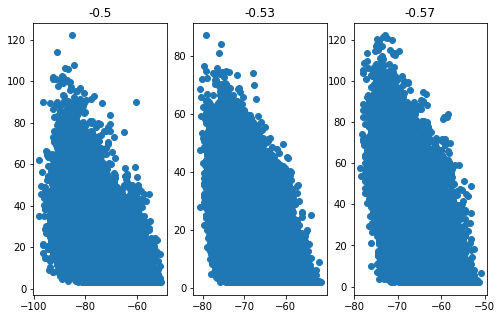

In [11]:
cp4s = [obs_gpm.tmin, obs_gpm.prcp] # gpm
cp25s = [hist.tmin, hist.prcp] #cp4
futur = [fut.tmin, fut.prcp] 


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(141)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(142)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(143)
plt.scatter(futur[0],futur[1])
r = stats.pearsonr(futur[0],futur[1])
plt.title(str(np.round(r[0], decimals=2)))


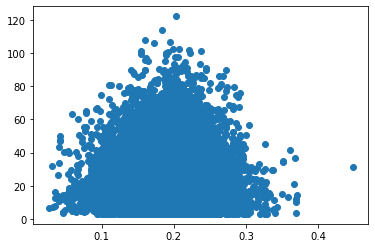

In [12]:
plt.scatter(obs_gpm.tgrad, obs_gpm.prcp)

In [13]:
oposi = (obs_gpm.q925>=8.) & (obs_gpm.shear>0) &  (obs_gpm.prcp>=8) & (obs_gpm.theta_e>=-40) & (obs_gpm.area>=5000) & (obs_gpm.tmin<=-55) # & ((obs_gpm.month>=9) | (obs_gpm.month<=5)) #0.1
cposi = (hist.q925>=8.) & (hist.shear>0) &  (hist.prcp>=8) & (np.isfinite(hist.q925)) & np.isfinite(hist.shear)  & (hist.area>=5000) & (hist.tmin<=-55)
fposi = (fut.q925>=8.) & (fut.shear>0) &  (fut.prcp>=8) & (np.isfinite(fut.q925)) & np.isfinite(fut.shear)  & (fut.area>=5000) & (fut.tmin<=-55)

In [14]:
obs = obs_gpm[oposi]
cp4 = hist[cposi]
cp4f = fut[fposi]
cp4.area = cp4.area.values

/home/ck/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [15]:
cp4.area.min()

5014.240000000001

In [16]:
obs.area.min()

5225

In [17]:
len(obs)

22576

In [18]:
len(cp4)

48023

In [19]:
len(cp4f)

37805

In [41]:
vlist=['prcp', 'tmin', 'area']
percentile = 95
obs_q925 = hist2d.create_2dhist_centile(obs.shear, obs.q925, shearbins, qbins, obs, vlist, percentile=percentile)
obs_theta = hist2d.create_2dhist_centile(obs.tcwv, obs.theta_e, tcwvbins, thetabins, obs, vlist, percentile=percentile)
obs_tcwv = hist2d.create_2dhist_centile(obs.shear, obs.tcwv, shearbins, tcwvbins, obs, vlist, percentile=percentile)

cp4_q925 = hist2d.create_2dhist_centile(cp4.shear, cp4.q925, shearbins, qbins, cp4, vlist, percentile=percentile)
cp4_tcwv = hist2d.create_2dhist_centile(cp4.shear, cp4.tcwv, shearbins, tcwvbins, cp4, vlist, percentile=percentile)
cp4_theta = hist2d.create_2dhist_centile(cp4.tcwv, cp4.theta_e, tcwvbins, thetabins, cp4, vlist, percentile=percentile)

cp4f_q925 = hist2d.create_2dhist_centile(cp4f.shear, cp4f.q925, shearbins, qbins, cp4f, vlist, percentile=percentile)
cp4f_tcwv = hist2d.create_2dhist_centile(cp4f.shear, cp4f.tcwv, shearbins, tcwvbins, cp4f, vlist, percentile=percentile)
cp4f_theta = hist2d.create_2dhist_centile(cp4f.shear, cp4f.theta_e, shearbins, thetabins, cp4f, vlist, percentile=percentile)

In [36]:
# shearbins = np.linspace(np.percentile(obs.shear,1.5),np.percentile(obs.shear,99), 23 )
# tcwvbins = np.linspace(np.percentile(obs.tcwv,1.8),np.percentile(obs.tcwv,99), 23 )
qbins = np.linspace(np.percentile(obs.q925,0.8),np.percentile(obs.q925,99.8), 23 )
q1 = 1
q2 = 99
shearbins = np.linspace(np.percentile(obs.shear,q1) ,np.max([np.percentile(obs.shear,q2),np.percentile(cp4.shear,q2)]),23) #np.min([np.percentile(obs.shear,q1),np.percentile(cp4.shear,q1)])
tcwvbins = np.linspace(np.min([np.percentile(obs.tcwv,q1),np.percentile(cp4.tcwv,q1)]) ,np.max([np.percentile(obs.tcwv,q2),np.percentile(cp4.tcwv,q2)]),23)

# shearbins = np.linspace(5,26, 23 )
# tcwvbins = np.linspace(27,56, 23 )

In [22]:
def run_binning(dic, scat):
    
    def linregress(bins,data, pval):
        data = np.array(data)
        pos = np.isfinite(data)
        inbins = bins[pos]
        indata = data[pos]
        return stats.linregress(inbins, indata)
    
    def weighted_regress(bins,data, pval):
        import statsmodels.api as sm
        data = np.array(data)
        pos = np.isfinite(data)
        inbins = bins#[pos]
        indata = data#[pos]
        inval = np.array(pval)#[pos]
        X = sm.add_constant(inbins)
        weight = inval / np.sum(inval)
        #ipdb.set_trace()
        return sm.WLS(indata,X, missing='drop', weights=weight).fit() # #, weights=weight

#     def linregress(bins,data, val):
#         data = np.array(data)
#         pos = np.isfinite(data)
#         val = np.array(val)
#         inbins = bins[pos]
#         indata = data[pos]
#         inval = val[pos]
        
#         slope, intercept, r_value, p_value, std_err = stats.linregress(inbins, indata)
        
#         wlr = sm.OLS(inbins, indata)  #, weights=1./inval
#         p = wlr.fit()
#         print(p.summary())
#         ipdb.set_trace()
#         #p.const + p.motifScore * x
#         return p.motifScore, p.const, 
    
    deltaPS, deltaQPS, sboxplot, tminbox,pmean,p90,p10, tmean, t90, t10, pval = binning_2dhist(dic['prcp'], dic['tmin'], scat, dic['prcp_val'])
    
    collbins = np.round(np.unique(scat),2)
    collbins = np.round(collbins[0:-1]+((collbins[1::]-collbins[0:-1])/2),2)
    
    linslope, linintercept, r_value, p_value, std_err = linregress(collbins[0:-1], pmean[0:-2], pval[0:-2])



    wls_model = weighted_regress(collbins, pmean[0:-1], pval[0:-1])
    #wls_model = weighted_regress(collbins[2:-3], pmean[2:-4], pval[2:-4])
    intercept = wls_model.params[0] #  intercept
    slope = wls_model.params[1] #  slope
    r_value = wls_model.rsquared  #rsquared

    
    odic = {
        'slope' : slope,
        'linintercept' : linintercept,
        'linslope' : linslope,
        'intercept' : intercept,
        'rval' : r_value,
        'pval' : p_value,
        'std_err' : std_err,
        'prcp_span' : deltaPS,
        'prcp_IQR' : deltaQPS,
        'pbox' : sboxplot,
        'tbox' : tminbox,
        'pmean' : pmean[0:-1],
        'p90' : p90[0:-1],
        'p10' : p10[0:-1],
        'tmean' : tmean[0:-1],
        't90' : t90[0:-1],
        't10' : t10[0:-1],
        'bins' : collbins
    }
    
    return odic

In [23]:
def binning_hist(bins, shape):
    scat = np.repeat(bins,shape[1],axis=0).reshape(shape)
    return scat

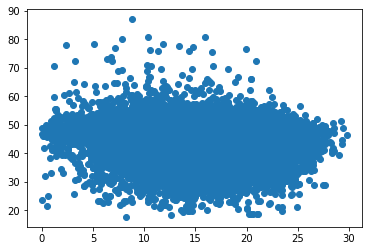

In [24]:
plt.scatter(cp4.shear, cp4.tcwv)

In [39]:
shape = obs_q925['prcp'].shape
shapet = obs_tcwv['prcp'].shape
shearscat = binning_hist(shearbins[np.newaxis,:],shape)
qscat = binning_hist(qbins,shape)
wvscat = binning_hist(tcwvbins,shapet)
thetascat = binning_hist(thetabins,shape)

In [26]:
def binning_2dhist(prcp, tmin, bins,valid):
    ps = []
    qps = []
    sbox = []
    tbox = []
    mean = []
    percup = []
    percdown = []
    tmean = []
    tpercup = []
    tpercdown = []
    pvals_hist = []
    pvals = []

    for sh in np.unique(bins):
        
            vvflag = True
            ttflag = True
        
            vals = prcp[(sh==bins)]
            valids = valid[(sh==bins)]
            vals[vals==0] = np.nan
            valids[vals==0] = np.nan
            tvals = tmin[sh==bins]
            tvals[tvals==0] = np.nan
            ps.append(np.nanmax(vals)-np.nanmin(vals))
            try:
                qps.append(np.percentile(vals[np.isfinite(vals)],75)-np.percentile(vals[np.isfinite(vals)],25))
            except:
                qps.append(np.nan)
            sbox.append(vals)
            
            vv = np.nanmean(vals)
            nans = np.sum(np.isnan(vals))
            if np.sum(np.isfinite(vals))<5:
                #ipdb.set_trace()
                vv = np.nan
                vvflag = False
            pvals_hist.append(np.sum(np.isfinite(vals)))
            pvals.append(np.nansum(valids))
            
            mean.append(vv)
            if vvflag:
                try:
                    percup.append(np.percentile(vals[np.isfinite(vals)],90))  #75,25
                    percdown.append(np.percentile(vals[np.isfinite(vals)],10))
                except:
                    percup.append(np.nan)
                    percdown.append(np.nan)
            else:
                percup.append(np.nan)
                percdown.append(np.nan)
                
                
               
            tvals[tvals==0] = np.nan
            tbox.append(tvals)
            
            tt = np.nanmean(tvals)
            nans = np.sum(np.isnan(tvals))
            if np.sum(np.isfinite(tvals))<5:
                tt = np.nan
                ttflag=False
            tmean.append(tt)
            
            if ttflag:
                try:
                    tpercup.append(np.percentile(tvals[np.isfinite(tvals)],75))
                    tpercdown.append(np.percentile(tvals[np.isfinite(tvals)],25))
                except:
                    tpercup.append(np.nan)
                    tpercdown.append(np.nan)
            else:
                tpercup.append(np.nan)
                tpercdown.append(np.nan)
                
               
                   
    print(np.median(np.array(qps)[np.isfinite(np.array(qps))]))
    return ps, qps, sbox, tbox, mean, percup, percdown, tmean, tpercup, tpercdown, pvals

In [27]:
# sbin = np.linspace(0,26.8,25)
# tbin = np.linspace(27,57,25)

sbin = np.linspace(0,26.7,28) #28
#tbin = np.linspace(27,57,28)

q1 = 0.8 #0.8
q2 = 99.5#99.5
#sbin = np.linspace(np.percentile(obs.shear,q1) ,np.max([np.percentile(obs.shear,q2),np.percentile(cp4.shear,q2)]),28) #np.min([np.percentile(obs.shear,q1),np.percentile(cp4.shear,q1)])
tbin = np.linspace(np.min([np.percentile(obs.tcwv,q1),np.percentile(cp4.tcwv,q1)]) ,np.max([np.percentile(obs.tcwv,q2),np.percentile(cp4.tcwv,q2)]),26)

testbins = [sbin,tbin]
func1 = lambda y: np.percentile(y,95, interpolation='nearest') #np.percentile(y, 95)
func2 = lambda y: np.sum(np.isfinite(y))
func3 = lambda y: np.sum(y>40)
ret = binned_statistic_2d(obs['shear'], obs['tcwv'], obs['prcp'], statistic=func1, bins=testbins)
count = binned_statistic_2d(obs['shear'], obs['tcwv'], obs['prcp'], statistic=func2, bins=testbins)
thresh = binned_statistic_2d(obs['shear'], obs['tcwv'], obs['prcp'], statistic=func3, bins=testbins)

In [28]:
ret4 = binned_statistic_2d(cp4['shear'], cp4['tcwv'], cp4['prcp'], statistic=func1, bins=testbins)
count4 = binned_statistic_2d(cp4['shear'], cp4['tcwv'], cp4['prcp'], statistic=func2, bins=testbins)

In [29]:
def gauss(data, sigma):
    sigma=sigma                  # standard deviation for Gaussian kernel
    truncate=4.0               # truncate filter at this many sigmas

    U=data       # random array...

    V=U.copy()
    V[np.isnan(U)]=0
    VV=ndimage.gaussian_filter(V,sigma=sigma,truncate=truncate)

    W=0*U.copy()+1
    W[np.isnan(U)]=0
    WW=ndimage.gaussian_filter(W,sigma=sigma,truncate=truncate)

    Z=VV/WW
    return Z

In [30]:
def run_small(data, count, testbins, axis=0):
    
    dd = gauss(data.statistic.T, 0.6)
    invalid = count.statistic.T < 10
    dd[invalid] = np.nan
    
    mean = np.nanmean(dd,axis=axis)
    val = np.nansum(np.isfinite(dd),axis=axis)
    
    mean[val<4] = np.nan
    
    perc = np.nanpercentile(dd, [10,90], axis=axis)
    
    def weighted_regress(bins,data, pval):
        import statsmodels.api as sm
        data = np.array(data)
        pos = np.isfinite(data)
        inbins = bins#[pos]
        indata = data#[pos]
        inval = np.array(pval)#[pos]
        X = sm.add_constant(inbins)
        weight = inval / np.sum(inval)
        #ipdb.set_trace()
        return sm.WLS(indata,X, missing='drop', weights=weight).fit() # #, weights=weight
    
    sbin = testbins[axis]
    bins = np.round(sbin[0:-1]+((sbin[1::]-sbin[0:-1])/2),2)
    fillmean = mean.copy()
    fillmean[np.isnan(fillmean)]=0

    val[np.isnan(fillmean)]=0
    wls_model = weighted_regress(bins[0:-3], fillmean[0:-3], val[0:-3])

    intercept = wls_model.params[0] #  intercept
    slope = wls_model.params[1] #  slope
    r_value = wls_model.rsquared  #rsquared
    
    #print(wls_model.summary())
    
    
   # ipdb.set_trace()
    
    odic = {
        'slope' : slope,
        'intercept' : intercept,
        'rval' : r_value,
        'pmean' :mean,
        'p90' : perc[0],
        'p10' : perc[1],
        'bins' : bins,
        'std_est' : wls_model.bse[0],
        'valid' : val,
        'model' : wls_model
    }
    
    return odic

In [37]:
f = plt.figure(figsize=(15,10), dpi=200)
colors=['k','lightblue','lightblue','b','b','r','r','r']
for ids, p in enumerate([0,25,50,60,70,90,95,99]):
    
#     if p == 0:
#         obs_tcwv = hist2d.create_2dhist(obs.shear, obs.tcwv, shearbins, tcwvbins, obs, vlist)
#         cp4_tcwv = hist2d.create_2dhist(cp4.shear, cp4.tcwv, shearbins, tcwvbins, cp4, vlist)
#         cp4f_tcwv = hist2d.create_2dhist(cp4f.shear, cp4f.tcwv, shearbins, tcwvbins, cp4f, vlist)
#     else: 
    obs_tcwv = hist2d.create_2dhist_centile(obs.shear, obs.tcwv, shearbins, tcwvbins, obs, vlist, percentile=p)
    cp4_tcwv = hist2d.create_2dhist_centile(cp4.shear, cp4.tcwv, shearbins, tcwvbins, cp4, vlist, percentile=p)
    cp4f_tcwv = hist2d.create_2dhist_centile(cp4f.shear, cp4f.tcwv, shearbins, tcwvbins, cp4f, vlist, percentile=p)

    obs_shear_tcwv = run_binning(obs_tcwv,wvscat)
    cp4_shear_tcwv = run_binning(cp4_tcwv,wvscat)
    cp4f_shear_tcwv = run_binning(cp4f_tcwv,wvscat)
    
    pobs = obs_shear_tcwv
    pcp4 = cp4_shear_tcwv
    pcp4f = cp4f_shear_tcwv
    
    if ids ==0:
        ax = f.add_subplot(231)
    ax.plot(pobs['bins'],pobs['pmean'],  color=colors[ids], marker='o',label=str(p))  #r'pobs | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pobs['slope'],2)
    ax.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color=colors[ids], alpha=0.3)
    ax.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
    ax.set_xlabel('TCWV (kg m$^{-2}$)')
    ax.set_ylabel('Average maximum rainfall (mm h$^{-1}$)')
    ax.set_title('Shading:IQR shear effect | p99 slope: ' + str(np.round(pobs['slope'],2)))
    #plt.ylim(10,42)
    #plt.ylim(15,33)
    ax.legend(loc='lower right')

    if ids ==0:
        ax1 = f.add_subplot(232)
    ax1.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color=colors[ids], alpha=0.3)
    ax1.plot(pcp4['bins'],pcp4['pmean'], color=colors[ids], marker='o', label=str(p))
    ax1.plot(pobs['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
    ax1.set_xlabel('TCWV (kg m$^{-2}$)')
    ax1.set_ylabel('Average maximum rainfall (mm h$^{-1}$)')
    ax1.set_title('Shading:IQR shear effect | p99 slope: '+ str(np.round(pcp4['slope'],2)))

    #plt.ylim(10,42)
    #plt.ylim(15,33)
    #plt.legend(loc='lower right')

    if ids ==0:
        ax2 = f.add_subplot(233)
    ax2.fill_between(pcp4f['bins'],pcp4f['p10'],pcp4f['p90'], color=colors[ids], alpha=0.3)
    ax2.plot(pcp4f['bins'],pcp4f['pmean'], color=colors[ids], marker='o',label=str(p))
    ax2.plot(pobs['bins'],pcp4f['slope']*pcp4f['bins']+pcp4f['intercept'], linestyle='dashed', color='k', linewidth=0.5)
    ax2.set_xlabel(r'TCWV (kg m$^{-2}$)')
    ax2.set_ylabel('Average maximum rainfall (mm h$^{-1}$)')
    ax2.set_title('Shading:IQR shear effect | p99 slope: '+ str(np.round(pcp4f['slope'],2)))
    
    
    if p==90:
        
        
        ax3 = f.add_subplot(234)
        ax3.plot(pobs['bins'],pobs['pmean'],  '-bo', label=r'pobs | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pobs['slope'],2)))
        ax3.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
        ax3.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
        ax3.fill_between(pcp4f['bins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
        ax3.plot(pcp4['bins'],pcp4['pmean'], color='orange', marker='o', label='pcp4 | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pcp4['slope'],2)))
        ax3.plot(pcp4f['bins'],pcp4f['pmean'], '-ro', label='pcp4future | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pcp4f['slope'],2)))
        ax3.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
        ax3.plot(pobs['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
        ax3.plot(pobs['bins'],pcp4f['slope']*pcp4f['bins']+pcp4f['intercept'], linestyle='dashed', color='k', linewidth=0.5)
        ax3.set_xlabel('TCWV (kg m$^{-2}$)')
        ax3.set_ylabel('Average maximum rainfall (mm h$^{-1}$)')
        ax3.set_title('Shading:25-75centile range (tcwv effect) | p'+str(p))
        #plt.ylim(10,42)
        #plt.ylim(15,33)
        ax3.legend(loc='lower right')
    if p==95:

        ax4 = f.add_subplot(235)
        ax4.plot(pobs['bins'],pobs['pmean'],  '-bo', label=r'pobs | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pobs['slope'],2)))
        ax4.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
        ax4.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
        ax4.fill_between(pcp4f['bins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
        ax4.plot(pcp4['bins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pcp4['slope'],2)))
        ax4.plot(pcp4f['bins'],pcp4f['pmean'], '-ro', label=r'pcp4future | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pcp4f['slope'],2)))
        ax4.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
        ax4.plot(pobs['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
        ax4.plot(pobs['bins'],pcp4f['slope']*pcp4f['bins']+pcp4f['intercept'], linestyle='dashed', color='k', linewidth=0.5)
        ax4.set_xlabel('TCWV (kg m$^{-2}$)')
        ax4.set_ylabel('Average maximum rainfall (mm h$^{-1}$)')
        ax4.set_title('Shading:25-75centile range (shear effect) | p'+str(p))

        #plt.ylim(10,42)
        #plt.ylim(15,33)
        ax4.legend(loc='lower right')

    if p==99:

        ax5 = f.add_subplot(236)
        ax5.plot(pobs['bins'],pobs['pmean'], '-bo', label=r'pobs | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pobs['slope'],3)))
        ax5.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
        ax5.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
        ax5.fill_between(pcp4f['bins'],pcp4f['p10'],pcp4f['p90'], color='red', alpha=0.3)
        ax5.plot(pcp4['bins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pcp4['slope'],3)))
        ax5.plot(pcp4f['bins'],pcp4f['pmean'], '-ro', label=r'pcp4 future | $\dfrac{\delta P}{\delta \theta _{e-es}}$: ' + str(np.round(pcp4f['slope'],3)))
        ax5.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
        ax5.plot(pobs['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
        ax5.plot(pobs['bins'],pcp4f['slope']*pcp4f['bins']+pcp4f['intercept'], linestyle='dashed', color='k', linewidth=0.5)
        ax5.set_xlabel(r'TCWV (kg m$^{-2}$)')
        ax5.set_ylabel('Average maximum rainfall (mm h$^{-1}$)')
        ax5.set_title('Shading:25-75centile range (shear effect) | p'+str(p))
        #plt.ylim(10,42)
        #plt.ylim(1,33)
        ax5.legend(loc='lower right')

        

plt.tight_layout()
plt.show()
#plt.savefig(cnst.network_data + 'figs/CLOVER/scatter_fullWA_pobs_pcp4future_monthly_pALL.png')

NameError: name 'wvscat' is not defined

<Figure size 3000x2000 with 0 Axes>

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys
/home/ck/miniconda3/lib/python3.7/site-packa

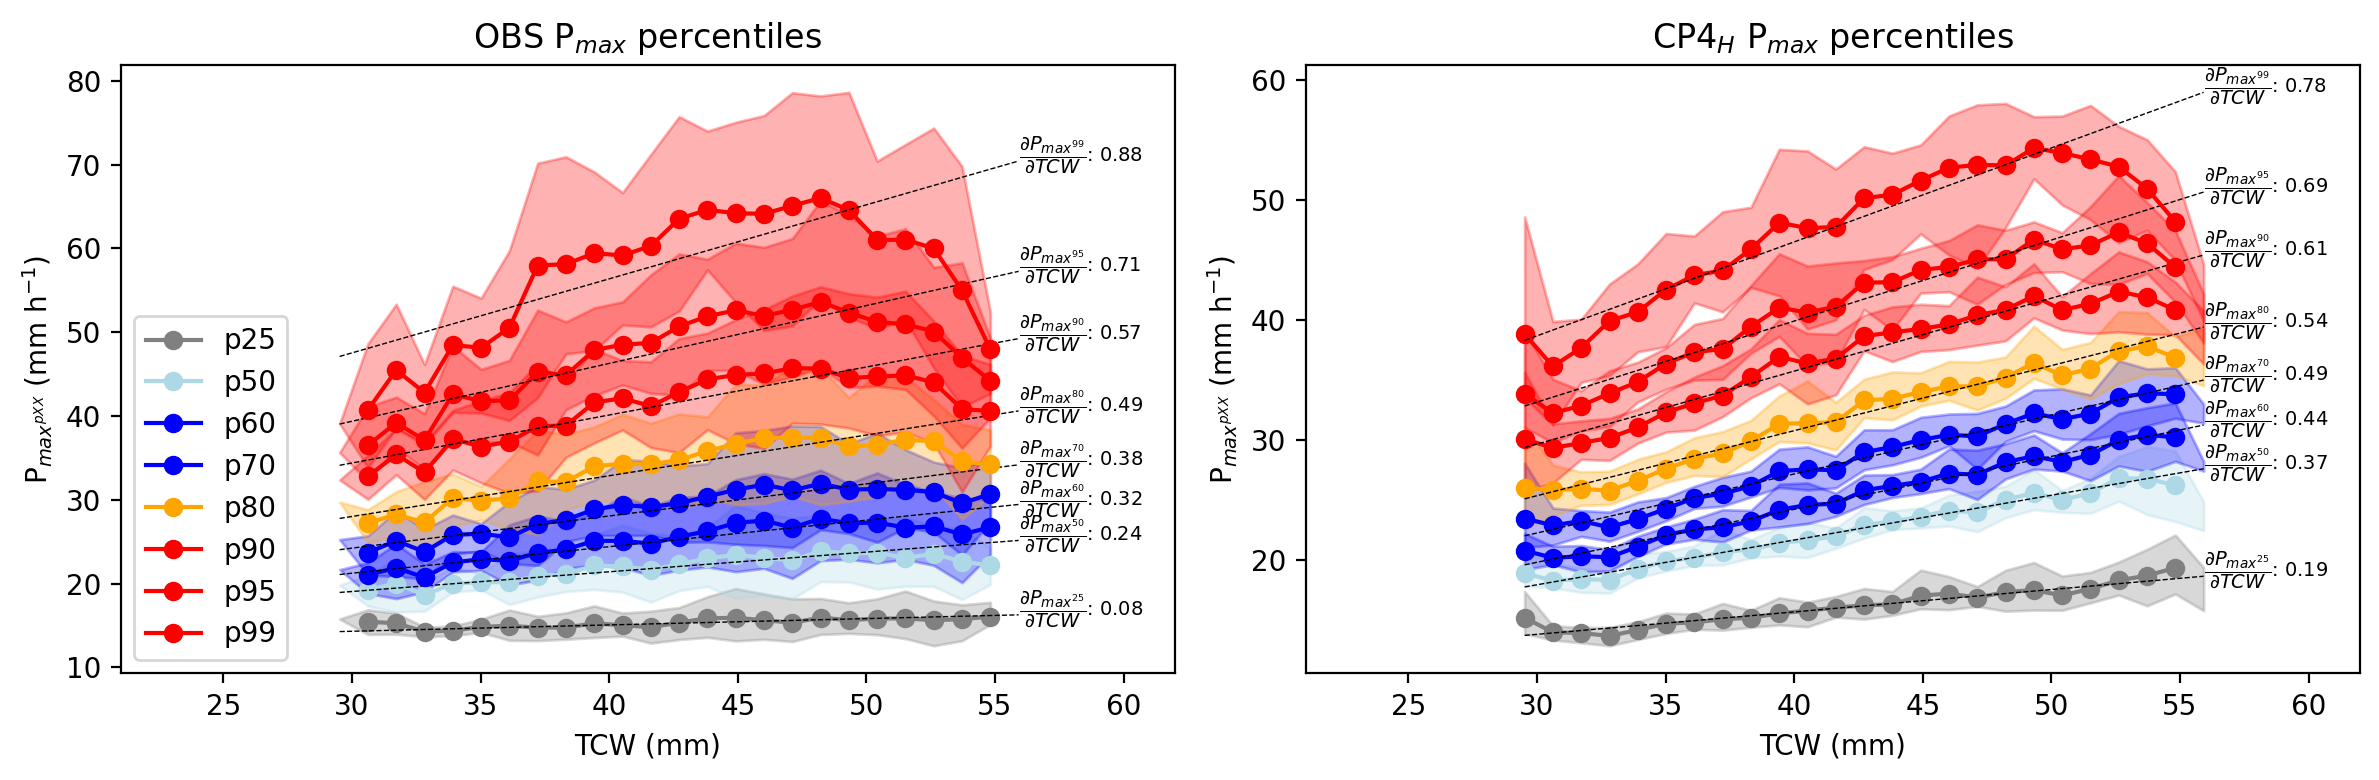

In [65]:
f = plt.figure(figsize=(12,4), dpi=200)
colors=['grey','lightblue','b','b','orange','r','r','r']
for ids, p in enumerate([25,50,60,70,80,90,95,99]):
    
    ret = binned_statistic_2d(obs['shear'], obs['tcwv'], obs['prcp'], statistic=lambda y: np.percentile(y, p), bins=testbins)
    count = binned_statistic_2d(obs['shear'], obs['tcwv'], obs['prcp'], statistic=lambda y: np.sum(np.isfinite(y)), bins=testbins)
    
    ret4 = binned_statistic_2d(cp4['shear'], cp4['tcwv'], cp4['prcp'], statistic=lambda y: np.percentile(y, p), bins=testbins)
    count4 = binned_statistic_2d(cp4['shear'], cp4['tcwv'], cp4['prcp'], statistic=lambda y: np.sum(np.isfinite(y)), bins=testbins)
    
    tdicobs = run_small(ret, count, testbins,axis=1)
    tdic4 = run_small(ret4, count4, testbins,axis=1)

    pobs = tdicobs
    pcp4 = tdic4
    
    if p ==95:
        adds = 0.02
    else: 
        adds = 0
    
    if ids ==0:
        ax = f.add_subplot(121)
    ax.plot(pobs['bins'],pobs['pmean'],  color=colors[ids], marker='o',label='p'+str(p))  #r'pobs | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pobs['slope'],2)
    ax.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color=colors[ids], alpha=0.3)
    ax.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
    ax.text(pobs['bins'][-1], (pobs['slope']*pobs['bins']+pobs['intercept'])[-1],'$\dfrac{\partial P_{max^{'+str(p)+'}}}{\partial TCW}$: ' + str(np.round(pobs['slope']+adds,2)), fontsize=7)
    ax.set_xlabel('TCW (mm)')
    ax.set_ylabel('P$_{max^{pXX}}$ (mm h$^{-1}$)')
    ax.set_title('OBS P$_{max}$ percentiles')
    plt.xlim(21,62)
    #plt.ylim(15,33)
    ax.legend(loc='lower left')
    
    if p ==95:
        adds = 0.01
    else:
        adds = 0
        
    if ids ==0:
        ax1 = f.add_subplot(122)
    ax1.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color=colors[ids], alpha=0.3)
    ax1.plot(pcp4['bins'],pcp4['pmean'], color=colors[ids], marker='o', label=str(p))
    ax1.plot(pcp4['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
    ax1.text(pcp4['bins'][-1], (pcp4['slope']*pcp4['bins']+pcp4['intercept'])[-1],'$\dfrac{\partial P_{max^{'+str(p)+'}}}{\partial TCW}$: ' + str(np.round(pcp4['slope']+adds,2)), fontsize=7)
    ax1.set_xlabel('TCW (mm)')
    ax1.set_ylabel('P$_{max^{pXX}}$ (mm h$^{-1}$)')
    ax1.set_title('CP4$_H$ P$_{max}$ percentiles')
    plt.xlim(21,62)

    
#     if p==90:
        
        
#         ax3 = f.add_subplot(223)
#         ax3.plot(pobs['bins'],pobs['pmean'],  '-bo', label=r'pobs | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pobs['slope'],2)))
#         ax3.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
#         ax3.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
#         ax3.plot(pcp4['bins'],pcp4['pmean'], color='orange', marker='o', label='pcp4 | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pcp4['slope'],2)))
#         ax3.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
#         ax3.plot(pobs['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
#         ax3.set_xlabel('TCWV (mm)')
#         ax3.set_ylabel('Average maximum rainfall (mm h$^{-1}$)')
#         ax3.set_title('Shading:25-75centile range (tcwv effect) | p'+str(p))
#         #plt.ylim(10,42)
#         #plt.ylim(15,33)
#         ax3.legend(loc='lower right')
#     if p==99:

#         ax4 = f.add_subplot(224)
#         ax4.plot(pobs['bins'],pobs['pmean'],  '-bo', label=r'pobs | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pobs['slope'],2)))
#         ax4.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
#         ax4.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
#         ax4.plot(pcp4['bins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pcp4['slope'],2)))
#         ax4.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
#         ax4.plot(pobs['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
#         ax4.set_xlabel('TCWV (mm)')
#         ax4.set_ylabel('Average maximum rainfall (mm h$^{-1}$)')
#         ax4.set_title('Shading:25-75centile range (shear effect) | p'+str(p))

#         #plt.ylim(10,42)
#         #plt.ylim(15,33)
#         ax4.legend(loc='lower left')

plt.tight_layout()
f.savefig(cnst.network_data + 'figs/ENDGAME/percentile_example.jpg')

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: All-NaN slice encountered
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice


3.0071137794631575
1.5565846626051831


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: All-NaN slice encountered
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice


4.45014701078815
1.9484154734540766


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: All-NaN slice encountered
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice


5.912538409040897
2.215059560629337


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: All-NaN slice encountered
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice


6.207253878321119
2.257614774893609


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: All-NaN slice encountered
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice


6.954443777955543
3.1024693587858305


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: All-NaN slice encountered
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice


8.256046040752253
3.6602941701775435


/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: All-NaN slice encountered
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice


13.361673879638651
6.328115573042471


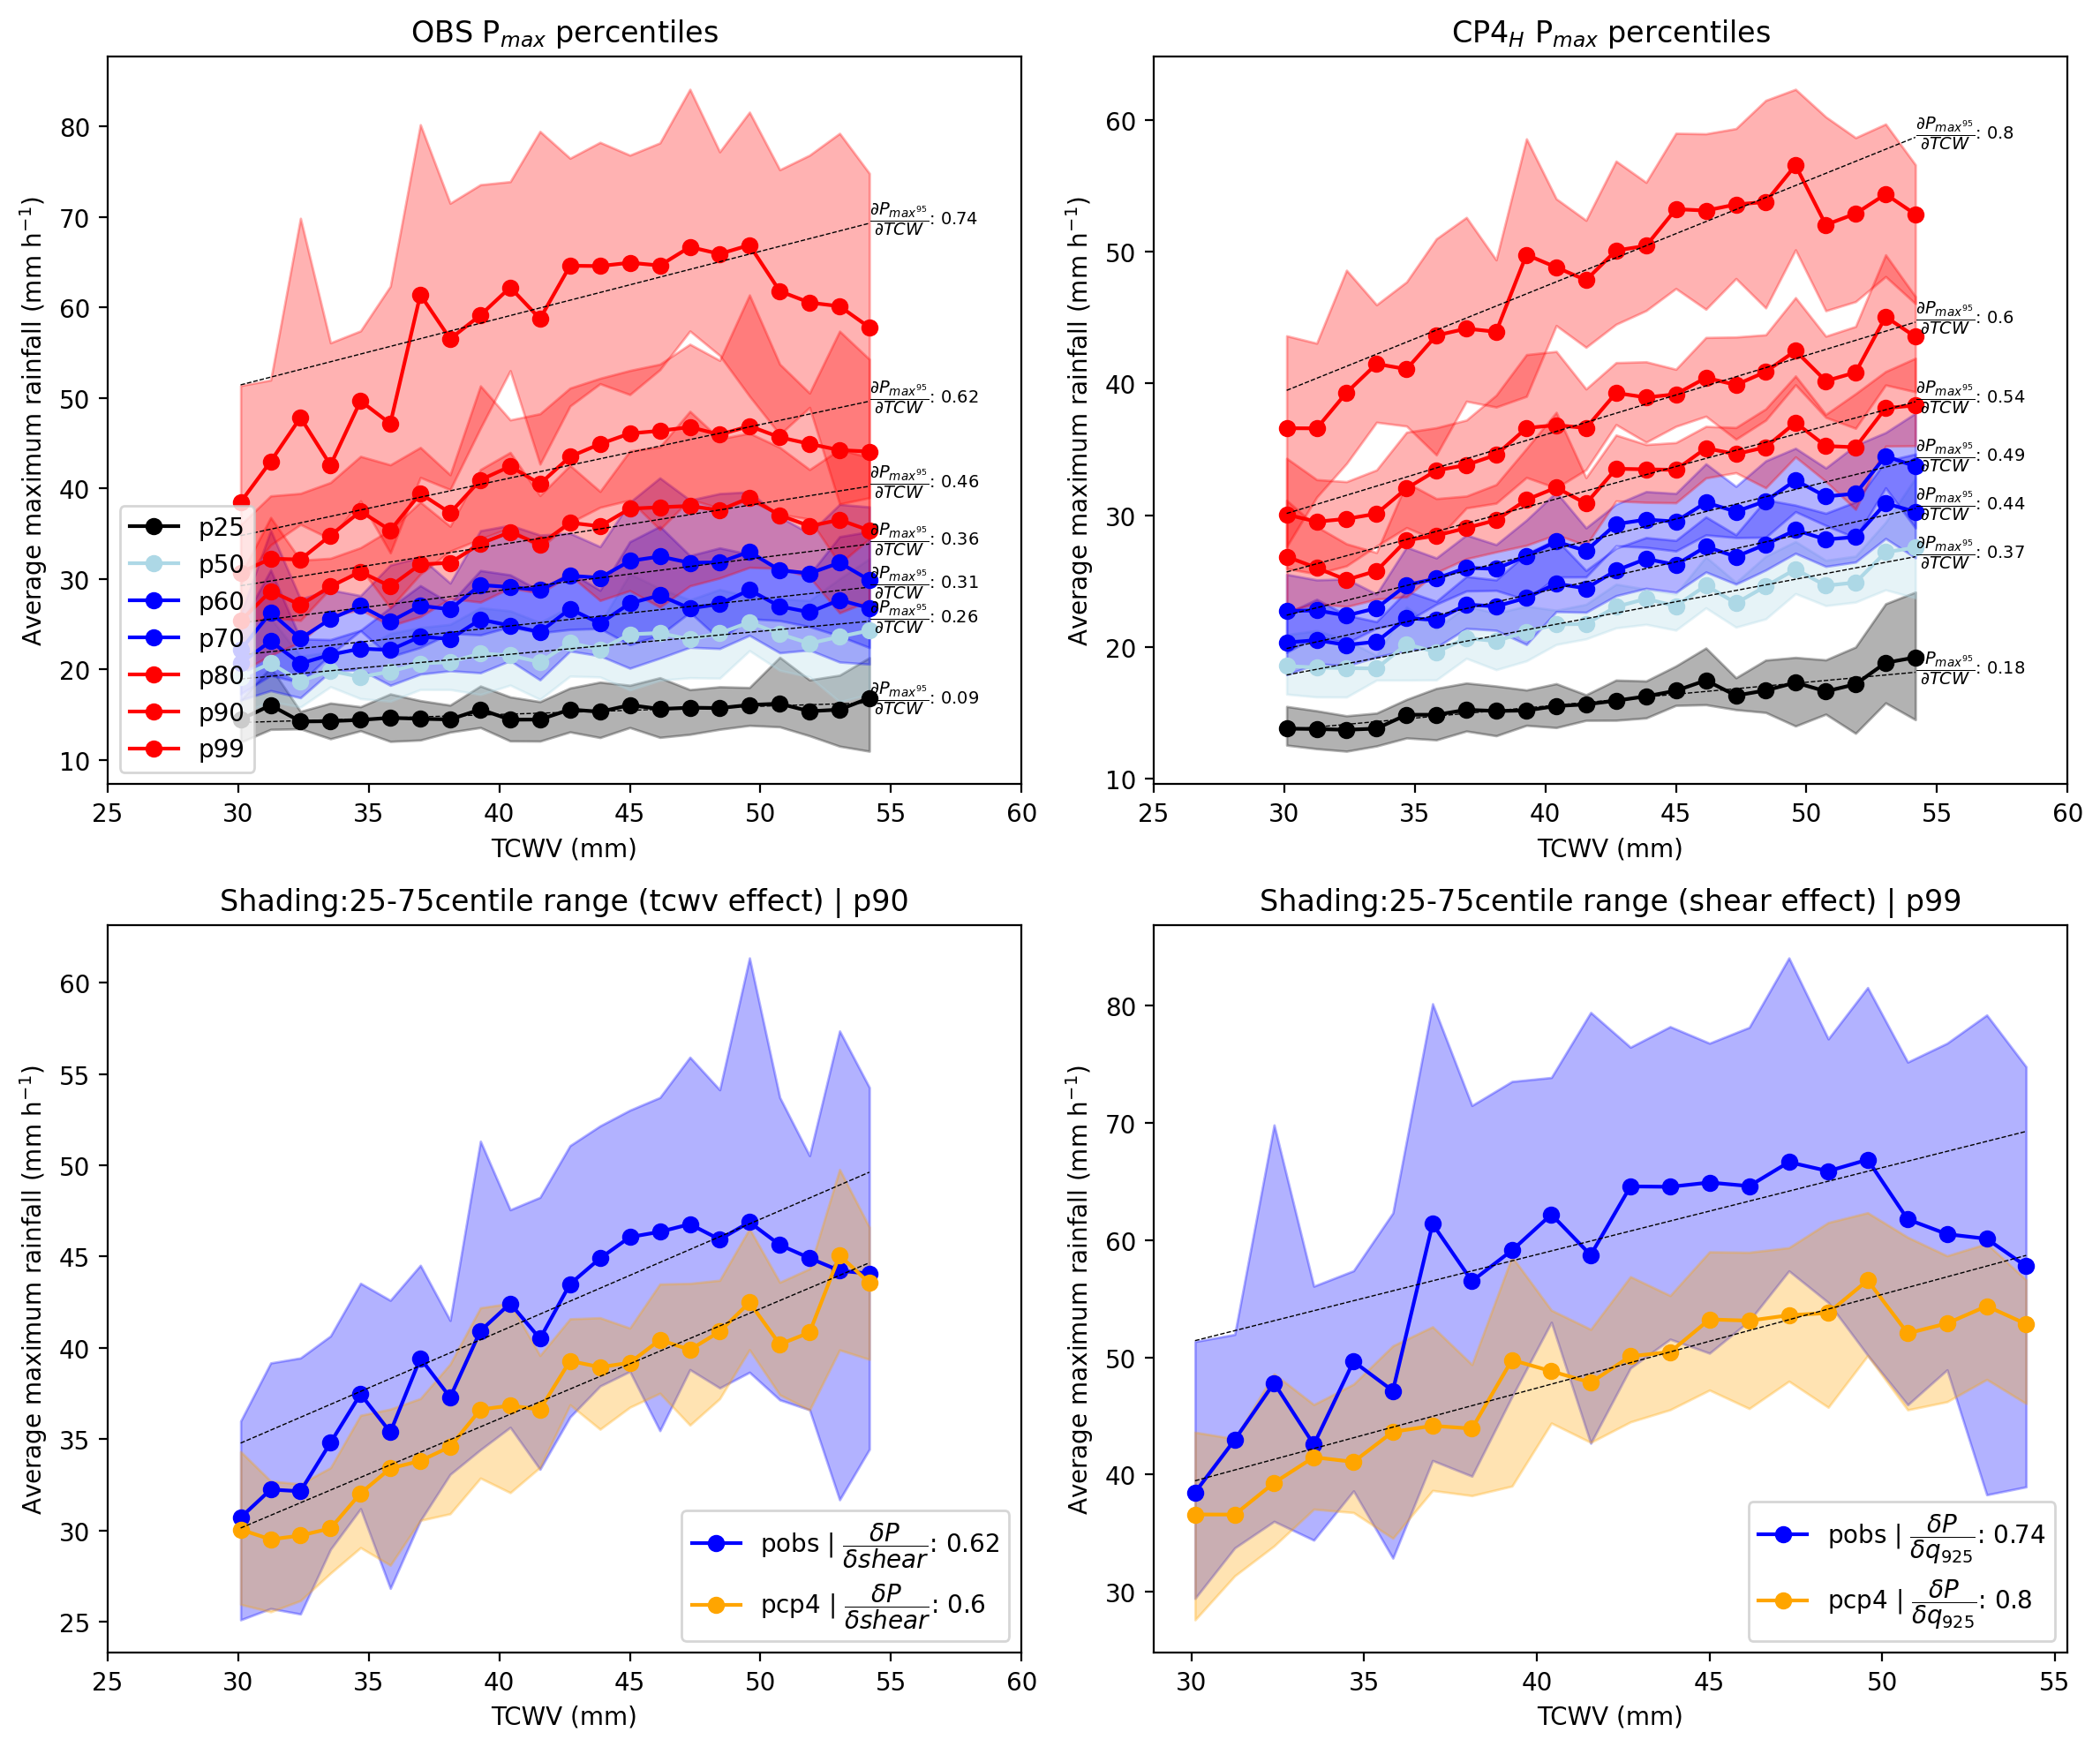

In [56]:

f = plt.figure(figsize=(12,10), dpi=200)
colors=['k','lightblue','b','b','r','r','r']
for ids, p in enumerate([25,50,60,70,80,90,99]):
    
#     if p == 0:
#         obs_tcwv = hist2d.create_2dhist(obs.shear, obs.tcwv, shearbins, tcwvbins, obs, vlist)
#         cp4_tcwv = hist2d.create_2dhist(cp4.shear, cp4.tcwv, shearbins, tcwvbins, cp4, vlist)
#         cp4f_tcwv = hist2d.create_2dhist(cp4f.shear, cp4f.tcwv, shearbins, tcwvbins, cp4f, vlist)
#     else: 
    obs_tcwv = hist2d.create_2dhist_centile(obs.shear, obs.tcwv, shearbins, tcwvbins, obs, vlist, percentile=p)
    cp4_tcwv = hist2d.create_2dhist_centile(cp4.shear, cp4.tcwv, shearbins, tcwvbins, cp4, vlist, percentile=p)
    #cp4f_tcwv = hist2d.create_2dhist_centile(cp4f.shear, cp4f.tcwv, shearbins, tcwvbins, cp4f, vlist, percentile=p)

    obs_shear_tcwv = run_binning(obs_tcwv,wvscat)
    cp4_shear_tcwv = run_binning(cp4_tcwv,wvscat)
    #cp4f_shear_tcwv = run_binning(cp4f_tcwv,wvscat)
    
    pobs = obs_shear_tcwv
    pcp4 = cp4_shear_tcwv
    #pcp4f = cp4f_shear_tcwv
    
    if ids ==0:
        ax = f.add_subplot(221)
    ax.plot(pobs['bins'],pobs['pmean'],  color=colors[ids], marker='o',label='p'+str(p))  #r'pobs | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pobs['slope'],2)
    ax.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color=colors[ids], alpha=0.3)
    ax.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
    ax.text(pcp4['bins'][-1], (pobs['slope']*pobs['bins']+pobs['intercept'])[-1],'$\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(pobs['slope'],2)), fontsize=7)
    ax.set_xlabel('TCWV (mm)')
    ax.set_ylabel('Average maximum rainfall (mm h$^{-1}$)')
    ax.set_title('OBS P$_{max}$ percentiles')
    plt.xlim(25,60)
    #plt.ylim(15,33)
    ax.legend(loc='lower left')

    if ids ==0:
        ax1 = f.add_subplot(222)
    ax1.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color=colors[ids], alpha=0.3)
    ax1.plot(pcp4['bins'],pcp4['pmean'], color=colors[ids], marker='o', label=str(p))
    ax1.plot(pobs['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
    ax1.text(pcp4['bins'][-1], (pcp4['slope']*pcp4['bins']+pcp4['intercept'])[-1],'$\dfrac{\partial P_{max^{95}}}{\partial TCW}$: ' + str(np.round(pcp4['slope'],2)), fontsize=7)
    ax1.set_xlabel('TCWV (mm)')
    ax1.set_ylabel('Average maximum rainfall (mm h$^{-1}$)')
    ax1.set_title('CP4$_H$ P$_{max}$ percentiles')
    plt.xlim(25,60)

    
    if p==90:
        
        
        ax3 = f.add_subplot(223)
        ax3.plot(pobs['bins'],pobs['pmean'],  '-bo', label=r'pobs | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pobs['slope'],2)))
        ax3.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
        ax3.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
        ax3.plot(pcp4['bins'],pcp4['pmean'], color='orange', marker='o', label='pcp4 | $\dfrac{\delta P}{\delta shear}$: ' + str(np.round(pcp4['slope'],2)))
        ax3.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
        ax3.plot(pobs['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
        ax3.set_xlabel('TCWV (mm)')
        ax3.set_ylabel('Average maximum rainfall (mm h$^{-1}$)')
        ax3.set_title('Shading:25-75centile range (tcwv effect) | p'+str(p))
        #plt.ylim(10,42)
        #plt.ylim(15,33)
        ax3.legend(loc='lower right')
    if p==99:

        ax4 = f.add_subplot(224)
        ax4.plot(pobs['bins'],pobs['pmean'],  '-bo', label=r'pobs | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pobs['slope'],2)))
        ax4.fill_between(pobs['bins'],pobs['p10'],pobs['p90'], color='blue', alpha=0.3)
        ax4.fill_between(pcp4['bins'],pcp4['p10'],pcp4['p90'], color='orange', alpha=0.3)
        ax4.plot(pcp4['bins'],pcp4['pmean'], color='orange', marker='o', label=r'pcp4 | $\dfrac{\delta P}{\delta q_{925}}$: ' + str(np.round(pcp4['slope'],2)))
        ax4.plot(pobs['bins'],pobs['slope']*pobs['bins']+pobs['intercept'], linestyle='dashed', color='k', linewidth=0.5)
        ax4.plot(pobs['bins'],pcp4['slope']*pcp4['bins']+pcp4['intercept'], linestyle='dashed', color='k', linewidth=0.5)
        ax4.set_xlabel('TCWV (mm)')
        ax4.set_ylabel('Average maximum rainfall (mm h$^{-1}$)')
        ax4.set_title('Shading:25-75centile range (shear effect) | p'+str(p))

        #plt.ylim(10,42)
        #plt.ylim(15,33)
        ax4.legend(loc='lower right')

plt.tight_layout()
plt.show()
#plt.savefig(cnst.network_data + 'figs/CLOVER/scatter_fullWA_pobs_pcp4future_monthly_pALL.png')